In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [14]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [15]:
#load the mnist dataset
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

In [16]:
#reduc the dataset to 1000 samples
mnist_train.data = mnist_train.data[:6000]
mnist_train.targets = mnist_train.targets[:6000]

In [17]:
#reduce mnist test to 100 samples
mnist_test.data = mnist_test.data[:100]
mnist_test.targets = mnist_test.targets[:100]

In [18]:
#split the training set into a training and validation set
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [5000, 1000])
print("Training set size: ", len(mnist_train))

Training set size:  5000


In [19]:
#create train and test loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False)

In [ ]:
#create a cnn architecture
class AttackCNN(nn.Module):
  def __init__(self):
    super(AttackCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    x = F.log_softmax(x, dim=1) #take log softmax here to use NLLLoss
    return x

In [ ]:
#create the model
attack_model = AttackCNN()
attack_model.to(device)
teacher_optimizer = optim.Adam(attack_model.parameters(), lr=0.0001)
teacher_loss = nn.NLLLoss()

In [ ]:
def train_attack_model(model, train_dataloader, val_loader, optimizer, loss_fn, num_epochs, CUDA=False, print_accs=True):

    traing_accs = []
    test_accs = []
    
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs+1):
        train_loss_per_epoch = 0
        val_loss_per_epoch = 0
        model.train()
        # Write training loop here
        for i, (X, y) in enumerate(train_dataloader):
            
            #send data to gpu
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()
            
            train_loss_per_epoch += loss.item()
        
        train_losses.append(train_loss_per_epoch)
        
        # Calculate training accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in train_dataloader:
                X = X.to(device)
                y = y.to(device)

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Training Accuracy: {correct / total}")
        traing_accs.append(correct / total)
        
        # Calculate test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                y = y.to(device)

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
                val_loss_per_epoch += loss_fn(y_pred, y).item()
        
        val_losses.append(val_loss_per_epoch)
                
        #print(f"Epoch {epoch}, Accuracy: {correct / total}")
        if print_accs:
            print(f"Epoch {epoch}, Training Accuracy: {traing_accs[-1]}, Validation Accuracy: {correct / total}, Training Loss: {train_loss_per_epoch}, Validation Loss: {val_loss_per_epoch}")
        
        test_accs.append(correct / total)
        # Do not forget to use model.train() and model.eval() before training and evaluation loops respectively.
    return traing_accs, test_accs, train_losses, val_losses
    

In [ ]:
#train the attack model
traing_accs, test_accs, train_losses, val_losses = train_attack_model(teacher_model, train_loader, val_loader, teacher_optimizer, teacher_loss, 10)

In [ ]:
#plot the training and validation loss and training and validation accuracy in one 2,1 subplot

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(train_losses, label="Training Loss")
ax[0].plot(val_losses, label="Validation Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(traing_accs, label="Training Accuracy")
ax[1].plot(test_accs, label="Validation Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
plt.legend()
plt.show()

In [20]:
class DefenseTeacher(nn.Module):
  def __init__(self):
    super(DefenseTeacher, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x


In [21]:
def train_defense_model(model, train_dataloader, val_loader, optimizer, loss_fn, num_epochs, CUDA=False, print_accs=True):
    temp = 100
    
    traing_accs = []
    test_accs = []
    
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs+1):
        train_loss_per_epoch = 0
        val_loss_per_epoch = 0
        model.train()
        # Write training loop here
        for i, (X, y) in enumerate(train_dataloader):
            
            #send data to gpu
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            
            #apply temperature scaling
            y_pred = y_pred / temp
            #apply softmax
            y_pred = F.log_softmax(y_pred, dim=1)
            
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()
            
            train_loss_per_epoch += loss.item()
        
        train_losses.append(train_loss_per_epoch)
        
        # Calculate training accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in train_dataloader:
                X = X.to(device)
                y = y.to(device)

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Training Accuracy: {correct / total}")
        traing_accs.append(correct / total)
        
        # Calculate test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                y = y.to(device)

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
                val_loss_per_epoch += loss_fn(y_pred, y).item()
        
        val_losses.append(val_loss_per_epoch)
                
        #print(f"Epoch {epoch}, Accuracy: {correct / total}")
        if print_accs:
            print(f"Epoch {epoch}, Training Accuracy: {traing_accs[-1]}, Validation Accuracy: {correct / total}, Training Loss: {train_loss_per_epoch}, Validation Loss: {val_loss_per_epoch}")
        
        test_accs.append(correct / total)
        # Do not forget to use model.train() and model.eval() before training and evaluation loops respectively.
    return traing_accs, test_accs, train_losses, val_losses
    
    

In [22]:
#define defense teacher model
defense_teacher_model = DefenseTeacher()
defense_teacher_model.to(device)
defense_teacher_optimizer = optim.Adam(defense_teacher_model.parameters(), lr=0.0001)
defense_teacher_loss = nn.NLLLoss()

In [23]:
#train the teacher model
traing_accs, test_accs, train_losses, val_losses = train_defense_model(defense_teacher_model, train_loader, val_loader, defense_teacher_optimizer, defense_teacher_loss, 10)

Epoch 1, Training Accuracy: 0.873, Validation Accuracy: 0.854, Training Loss: 5577.624593738366, Validation Loss: -383244.68906873465
Epoch 2, Training Accuracy: 0.9038, Validation Accuracy: 0.889, Training Loss: 2831.0988393428534, Validation Loss: -462282.25272363424
Epoch 3, Training Accuracy: 0.9208, Validation Accuracy: 0.908, Training Loss: 2373.8080788720017, Validation Loss: -528705.0954942703
Epoch 4, Training Accuracy: 0.9286, Validation Accuracy: 0.916, Training Loss: 2195.071936399524, Validation Loss: -558019.7496585846
Epoch 5, Training Accuracy: 0.929, Validation Accuracy: 0.907, Training Loss: 2007.4764238918538, Validation Loss: -562964.7408804893
Epoch 6, Training Accuracy: 0.9386, Validation Accuracy: 0.921, Training Loss: 1868.302539732164, Validation Loss: -573201.4965355396
Epoch 7, Training Accuracy: 0.9454, Validation Accuracy: 0.917, Training Loss: 1816.5073409205972, Validation Loss: -543979.819703579
Epoch 8, Training Accuracy: 0.9478, Validation Accuracy: 0.

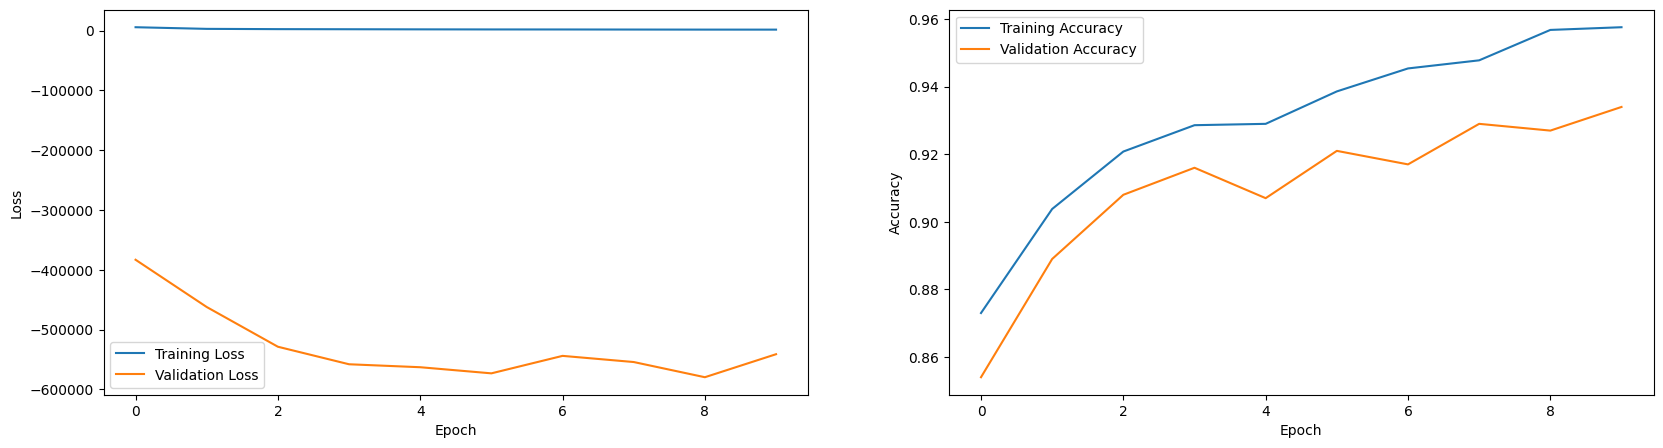

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(train_losses, label="Training Loss")
ax[0].plot(val_losses, label="Validation Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(traing_accs, label="Training Accuracy")
ax[1].plot(test_accs, label="Validation Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
plt.legend()
plt.show()

IndexError: index 1 is out of bounds for dimension 0 with size 1

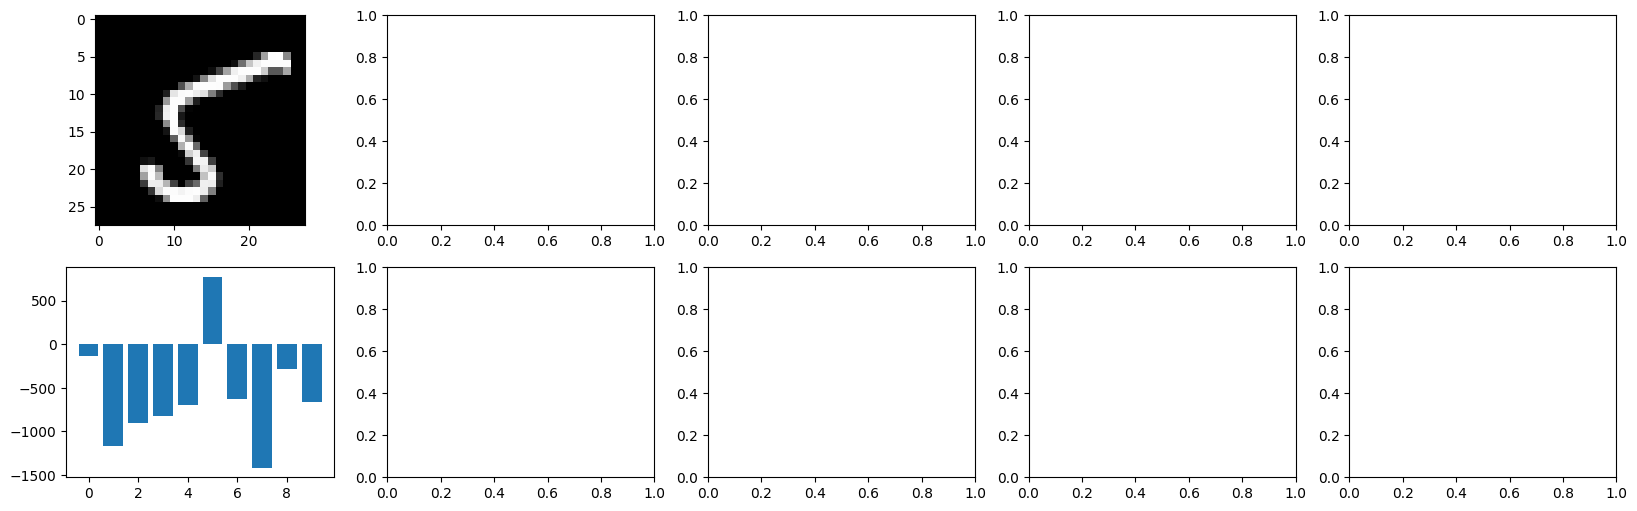

In [25]:
#valdate the output of the teacher model

#create 5 x 2 subplot
fig, ax = plt.subplots(2, 5, figsize=(20, 6))

for X, y in train_loader:
    X = X.to(device)
    y = y.to(device)
    y_pred = defense_teacher_model(X)
    
    #plot the first 5 images and their predictions
    for i in range(5):
        ax[0, i].imshow(X[i].cpu().numpy().reshape(28, 28), cmap='gray')
        #plot the predicted probability distribution
        ax[1, i].bar(range(10), y_pred[i].cpu().detach().numpy())
    break

In [26]:
import torch
from torch.utils.data import Dataset

class TeacherOutputDataset(Dataset):
    def __init__(self, images, teacher_probs, labels):
        self.images = images
        self.teacher_probs = teacher_probs
        self.labels = labels

    def __getitem__(self, index):
        image = self.images[index]
        teacher_prob = self.teacher_probs[index]
        label = self.labels[index]
        return image, teacher_prob, label

    def __len__(self):
        return len(self.images)


In [36]:
#Create a new dataset with the teacher model predictions

def create_teach_model_dataset(teacher_model) -> torch.utils.data.TensorDataset:
    teacher_model.eval()
    teacher_input = []
    teacher_predicted_probailities = []
    true_labels = []
    with torch.no_grad():
        for X, y in train_loader:
            X = X.to(device)
            y.to(device)
            y_pred = teacher_model(X)
            #normilize the probabilities
            teacher_input.append(X)
            teacher_predicted_probailities.append(y_pred)
            true_labels.append(y)

    teacher_input = torch.cat(teacher_input)
    teacher_predicted_probailities = torch.cat(teacher_predicted_probailities)
    true_labels = torch.cat(true_labels)
    
    #create the custom dataset
    teacher_dataset = TeacherOutputDataset(teacher_input, teacher_predicted_probailities, true_labels)
    
    #create the loader
    teacher_loader = torch.utils.data.DataLoader(teacher_dataset, batch_size=1, shuffle=True)
    
    return teacher_dataset, teacher_loader


In [37]:
teacher_dataset, teacher_loader = create_teach_model_dataset(defense_teacher_model)

/Users/loganfalzarano/anaconda3/envs/mlma/lib/python3.10/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


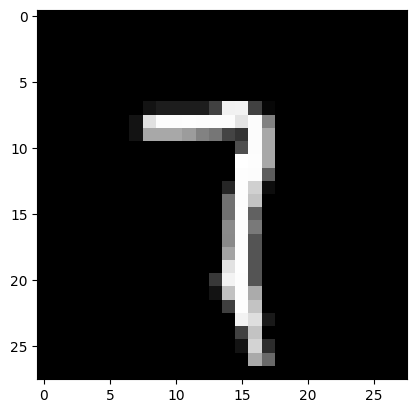

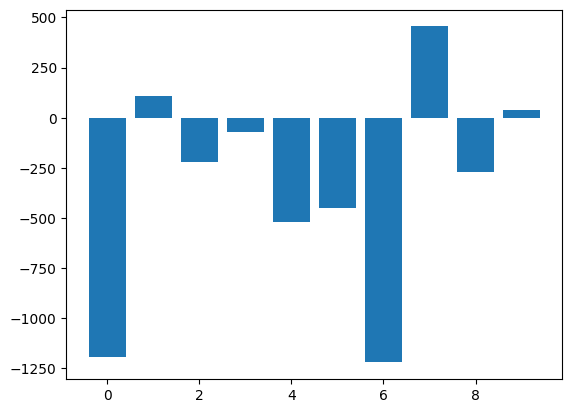

sum is
-3346.1257
[-1191.5514     110.04154   -222.08958    -72.85515   -521.4556
  -448.69     -1220.8071     454.95435   -271.0845      37.411983]
tensor([-1191.5514,   110.0415,  -222.0896,   -72.8551,  -521.4556,  -448.6900,
        -1220.8071,   454.9543,  -271.0845,    37.4120], device='mps:0')
tensor(7)


In [38]:
#plot the first image with the teacher model output and true label
image_example = teacher_dataset[13]

plt.imshow(image_example[0].cpu().squeeze().numpy(), cmap='gray')
plt.show()

probs = image_example[1].cpu().numpy()
#plot the predicted probability distribution
plt.bar(range(10), probs)
plt.show()

#sum of hte probs should be 1
print("sum is")
print(np.sum(probs))

#print the probabilities rounded to 2 decimal places
print(np.round(probs, 6))

print(image_example[1])
print(image_example[2])
plt.show()


In [39]:
class DefenseStudent(nn.Module):
  def __init__(self):
    super(DefenseStudent, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    x = F.softmax(x, dim=1)
    return x

In [40]:
#create student model
student_model = DefenseStudent()
student_model.to(device)
student_optimizer = optim.Adam(student_model.parameters(), lr=0.0001)
student_loss = nn.NLLLoss()

In [41]:
def train_model_student(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, CUDA=False, print_accs=True):
    temp = 100

    traing_accs = []
    test_accs = []

    for epoch in range(1, num_epochs+1):
        
        model.train()
        # Write training loop here
        for i, (X, y, l) in enumerate(train_dataloader):
            
            X = X.to(device)
            y = y.to(device)            
            
            optimizer.zero_grad()
            y_pred = model(X)
            
            #apply softmax
            y_pred = F.log_softmax(y_pred / temp, dim=1)
            
            #squueze batch dimension
            y = y.squeeze()
            y_pred = y_pred.squeeze()
            
            #here the loss function calculates the cross entropy loss using a two probability distributions
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()

        # Write evaluation loop(s) here
        
        # Calculate training accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y, l in train_dataloader:
                
                X = X.to(device)
                y = y.to(device)
                
                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                _, true_classes = torch.max(y, dim=1)
                
                total += y.size(0)
                correct += (predicted == true_classes).sum().item()
                
        #print(f"Epoch {epoch}, Training Accuracy: {correct / total}")
        traing_accs.append(correct / total)
        
        # Calculate test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_dataloader:
                
                X = X.to(device)
                y = y.to(device)

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Accuracy: {correct / total}")
        if print_accs:
            print(f"Epoch {epoch}, Training Accuracy: {traing_accs[-1]}, Validation Accuracy: {correct / total}")
        
        test_accs.append(correct / total)
        # Do not forget to use model.train() and model.eval() before training and evaluation loops respectively.
    return traing_accs, test_accs
    

In [42]:
#train the student model
traing_accs, test_accs = train_model_student(student_model, teacher_loader, val_loader, student_optimizer, student_loss, 10)

: 

: 

: 

In [ ]:
#get first image from the training set
image_example = teacher_dataset[44]

#print the image
plt.imshow(image_example[0].cpu().squeeze().numpy(), cmap='gray')
plt.show()

#run it through teacher to get probabilities
defense_teacher_model.eval()
teacher_probs = defense_teacher_model(image_example[0].unsqueeze(0).to(device))

#run the same image through the student model
student_model.eval()
student_probs = student_model(image_example[0].unsqueeze(0).to(device))

#plot the teacher and student probabilities
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].bar(range(10), teacher_probs.cpu().detach().numpy().squeeze())
ax[0].set_title("Teacher Model Probabilities")

ax[1].bar(range(10), student_probs.cpu().detach().numpy().squeeze())
ax[1].set_title("Student Model Probabilities")

plt.show()

In [ ]:
from fgsm import create_fgsm_adversarial_example
from fgsm import can_import

In [ ]:
can_import()

In [ ]:
def create_fgsm_adversarial_example(model, criterion, X, y, epsilon):
    X.requires_grad = True
    model.zero_grad()
    
    X = X.to(device)
    X.retain_grad()
    y = y.to(device)
    
    output = model(X)
    model_prediction_unperturbed = output.argmax(dim=1)
    prediction_confidence = F.softmax(output, dim=1).max()
    loss = criterion(output, y)
    loss.backward()
    
    x_grad = X.grad
    x_adv = X + epsilon * x_grad.sign()
    
    #clamp
    x_adv = torch.clamp(x_adv, 0, 1)
    return model_prediction_unperturbed, prediction_confidence, x_adv

In [ ]:
#get one image
ex = teacher_dataset[8]
X = ex[0]
print(X)

#create adversarial example
model_prediction_unperturbed, prediction_confidence, x_adv = create_fgsm_adversarial_example(teacher_model, teacher_loss, X.unsqueeze(0), ex[2].unsqueeze(0), 0.1)

#plot perturbed image
plt.imshow(x_adv.detach().cpu().squeeze().numpy(), cmap='gray')

#print max image intensity
print(x_adv.max())

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def evaluate_model_on_adversarial_input(model, model_criterion, test_dataloader, epsilon=0.1):
    
    #set batch size of 1
    test_dataloader = torch.utils.data.DataLoader(test_dataloader.dataset, batch_size=1, shuffle=False)
    
    raw_image_prections = []
    adv_image_predictions = []
    true_labels = []
    
    for X, y in test_dataloader:
        
        X = X.to(device)
        y = y.to(device)
        
        true_labels.append(y)
        
        #get the predictions on the raw image
        raw_image_prediction = model(X)
        _, raw_image_predicted = torch.max(raw_image_prediction.data, 1)
        raw_image_prections.append(raw_image_predicted)
        
        #create adversarial example
        _, _, x_adv = create_fgsm_adversarial_example(model, model_criterion, X, y, epsilon)
        
        #get the predictions on the adversarial image
        adv_image_prediction = model(x_adv)
        _, adv_image_predicted = torch.max(adv_image_prediction.data, 1)
        adv_image_predictions.append(adv_image_predicted)
            
    #concatenate the predictions
    raw_image_prections = torch.cat(raw_image_prections)
    adv_image_predictions = torch.cat(adv_image_predictions)
    true_labels = torch.cat(true_labels)
                
    return raw_image_prections, adv_image_predictions, true_labels

In [ ]:
#evaluate the student model on adversarial examples

raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(teacher_model, teacher_loss, test_loader, epsilon=0.1)

In [ ]:
#calculate the accuracy on raw and adversarial examples

#convert the predictions to numpy
raw_image_prections = raw_image_prections.cpu().numpy()
adv_image_predictions = adv_image_predictions.cpu().numpy()
true_labels = true_labels.cpu().numpy()

In [ ]:


#calculate confusion matrices
from sklearn.metrics import confusion_matrix
raw_image_confusion_matrix = confusion_matrix(true_labels, raw_image_prections)
adv_image_confusion_matrix = confusion_matrix(true_labels, adv_image_predictions)

#plot the confusion matrices
import seaborn as sns


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(raw_image_confusion_matrix, annot=True, fmt='g')
plt.title('Raw Image Confusion Matrix')
plt.subplot(1, 2, 2)
sns.heatmap(adv_image_confusion_matrix, annot=True, fmt='g')
plt.title('Adversarial Image Confusion Matrix')
plt.show()




In [ ]:
#evaluate accuracy for a range of epsilon values

epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
accuracies = []

for eps in epsilons:
    raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(teacher_model, teacher_loss, test_loader, epsilon=eps)
    
    #calculate the accuracy on raw and adversarial examples
    raw_image_accuracy = (raw_image_prections == true_labels).sum().item() / len(true_labels)
    adv_image_accuracy = (adv_image_predictions == true_labels).sum().item() / len(true_labels)
    
    accuracies.append((raw_image_accuracy, adv_image_accuracy))



In [ ]:
#plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(epsilons, [a[0] for a in accuracies], 'b*-')
plt.plot(epsilons, [a[1] for a in accuracies], 'r*-')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title('Teacher Model Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend(['Raw Image', 'Adversarial Image'])
plt.show()

In [ ]:
#evaluate the student model on adversarial examples
raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(student_model, student_loss, test_loader, epsilon=0.5)

In [ ]:
#calculate the accuracy on raw and adversarial examples

#convert the predictions to numpy
raw_image_prections = raw_image_prections.cpu().numpy()
adv_image_predictions = adv_image_predictions.cpu().numpy()
true_labels = true_labels.cpu().numpy()

In [ ]:
#calculate confusion matrices for sutdent model
raw_image_confusion_matrix = confusion_matrix(true_labels, raw_image_prections)
adv_image_confusion_matrix = confusion_matrix(true_labels, adv_image_predictions)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(raw_image_confusion_matrix, annot=True, fmt='g')
plt.title('Raw Image Confusion Matrix')
plt.subplot(1, 2, 2)
sns.heatmap(adv_image_confusion_matrix, annot=True, fmt='g')
plt.title('Adversarial Image Confusion Matrix')
plt.show()

In [ ]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
accuracies = []

for eps in epsilons:
    raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(student_model, student_loss, test_loader, epsilon=eps)
    
    #calculate the accuracy on raw and adversarial examples
    raw_image_accuracy = (raw_image_prections == true_labels).sum().item() / len(true_labels)
    adv_image_accuracy = (adv_image_predictions == true_labels).sum().item() / len(true_labels)
    
    accuracies.append((raw_image_accuracy, adv_image_accuracy))
    

In [ ]:
#plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(epsilons, [a[0] for a in accuracies], 'b*-')
plt.plot(epsilons, [a[1] for a in accuracies], 'r*-')
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend(['Raw Image', 'Adversarial Image'])
plt.show()

In [ ]:
#print first image from training set
image_example = teacher_dataset[80]

plt.imshow(image_example[0].cpu().squeeze().numpy(), cmap='gray')
print(image_example[1])
print(image_example[2])
plt.show()

#create adverarial example
model_prediction_unperturbed, prediction_confidence, x_adv = create_fgsm_adversarial_example(teacher_model, teacher_loss, image_example[0].unsqueeze(0), image_example[2].unsqueeze(0), 0.9)

#plot adversarial example
plt.imshow(x_adv.detach().cpu().squeeze().numpy(), cmap='gray')

#plot the difference between the original and adversarial image
plt.imshow((x_adv - image_example[0]).detach().cpu().squeeze().numpy(), cmap='gray')



In [ ]:
#plot the first image from the student dataset

im = train_loader.dataset[0][0].squeeze().numpy()
label = train_loader.dataset[0][1]
plt.imshow(im, cmap='gray')
plt.title(f'True Label: {label}')

In [ ]:
#create an adversarial example
input_label = train_loader.dataset[1][1]

#convert y to tensor
y_tensor = torch.tensor([input_label])

print(train_loader.dataset[1][0].shape)
print(y_tensor)

model_prediction_unperturbed, prediction_confidence, x_adv = create_fgsm_adversarial_example(student_model, student_loss, test_loader.dataset[1][0], y_tensor, epsilon=0.3)


#plot the orginal image
plt.imshow(test_loader.dataset[1][0].squeeze().numpy(), cmap='gray')
plt.title(f'True Label: {input_label}')
plt.show()

In [ ]:
#plot the adversarial image
plt.imshow(x_adv.cpu().squeeze().detach().numpy(), cmap='gray')

In [ ]:
print(x_adv.shape)

In [ ]:
#make a prediction on the orginal image
teacher_output = teacher_model(x_adv)
#apply softmax
teacher_output = F.softmax(teacher_output, dim=1)
#convert to numpy array
teacher_output = teacher_output.detach().numpy()
#plot student output
plt.bar(range(10), teacher_output[0])
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title("Teacher Model predicted probalities")
plt.show()

student_output = student_model(x_adv)
# apply softmax
student_output = F.softmax(student_output, dim=1)
# convert to numpy array
student_output = student_output.detach().numpy()

# plot student output
plt.bar(range(10), student_output[0])
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title("Student Model predicted probalities")
plt.show()


### We can see here that the teacher model incorrectly predicts class 2 for the image whereas the student model is able to correctly classify the perturbed image. This is a clear indication that the student model is more robust to adversarial attacks than the teacher model.